## ResNet

In [1]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.11.0  Device: cuda


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [5]:
''' 3. Data Augmentation이 적용된 CIFAR10 데이터 다운로드 (Train set, Test set 분리하기) '''
train_dataset = datasets.CIFAR10(root = "./data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

test_dataset = datasets.CIFAR10(root = "./data/CIFAR_10",
                                train = False,
                                transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


In [6]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

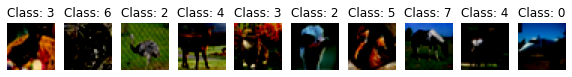

In [7]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [8]:
''' 6. ResNet 모델 설계하기 '''
# ResNet 모델은 내부에 반복적으로 이용하는 Block을 바탕으로 구성되기 때문에, 반복적으로 이용하는 Block을 먼저 정의한 후 정의된 Block을 바탕으로 ResNet 구현
class BasicBlock(nn.Module): # nn.Module을 상속받는 클래스로 정의해 nn.Module 클래스가 이용할 수 있는 함수를 그대로 이용
    def __init__(self, in_planes, planes, stride = 1): # BasicBlock 클래스의 인스턴스를 생성했을 때 지니게 되는 성질을 정의 (in_planes, planes, stride를 인자로 받았을 때 인스턴스 생성)
        super(BasicBlock, self).__init__() # nn.Module 내에 있는 메서드를 상속 받아 이용
        self.conv1 = nn.Conv2d(in_planes, planes, # 2차원 이미지 데이터를 Conv2d를 이용해 Convolution 연산을 하는 필터를 정의, 이 때 Input으로 이용되는 데이터의 채널 수 in_planes 값은 인스턴스 생성시 인자로 받음 (필터의 개수도 동일)
                                 kernel_size = 3, # 이용하는 필터의 크기를 3 * 3 으로 설정
                                 stride = stride,  # 필터가 움직이는 단위를 인스턴스 생성시 인자 값으로 받은 것으로 설정
                                 padding = 1, # 이미지의 구석 부분이 중앙보다 상대적으로 덜 연산되는 것을 막기 위해 테두리를 0으로 채움
                                 bias = False) # Convolution 연산을 진행할 때, 이미지의 각 픽셀 값, 필터의 파라미터 값, Convolution 연산을 한 이후 Bias 값을 더해줄 것인지 선택
        self.bn1 = nn.BatchNorm2d(planes) # 각 Layer마다 Input 분포가 달라짐에 따라 학습 속도가 현저히 느려짐을 방지, Input으로 받은 planes 크기의 데이터에 적용할 수 있도록 BatchNorm2d 정의
        # 2차원의 이미지 데이터를 nn.Conv2d를 이용해 Convolution 연산을 하는 필터를 정의
        self.conv2 = nn.Conv2d(planes, planes, # 인스턴스 생성 시 정의한 Planes 인자 값으로 필터 채널의 수(in channel)와, 필터의 개수(out channel)를 설정
                                # Conv2 를 이용해 Feature Map을 생성했을 때, 채널의 수는 변하지 않음 (in channel = out channel)
                                kernel_size = 3, 
                                stride = 1, 
                                padding = 1, 
                                bias = False)
        self.bn2 = nn.BatchNorm2d(planes) # planes 크기의 데이터에 대해 적용할 수 있는 BatchNorm2d를 정의
        
        # ResNet의 특징인 Shortcut을 정의하는 부분 = Shortcut은 기존의 값과 Convolution 및 Batch Normalization한 결과를 더하는 과정을 의미
        self.shortcut = nn.Sequential() 
        if stride != 1 or in_planes != planes: # stride 값이 1이 아니거나, in_planes가 Planes와 같지 않다면, 즉 두 번째 블록부터 적용되는 shortcut을 정의
            self.shortcut = nn.Sequential( # 위 조건을 바탕으로 적용되는 shortcut을 정의
                nn.Conv2d(in_planes, planes, # 2차원 이미지 데이터를 nn.Conv2d 메서드를 이용해 Convolution 연산을 하는 필터 정의
                            kernel_size = 1, # 이 때 적용되는 필터의 크기는 1
                            stride = stride, 
                            bias = False),
                nn.BatchNorm2d(planes))
    
    def forward(self, x): # BasicBlock의 Forward Propagation을 정의. 즉, 설계한 BasicBlock에 데이터를 입력했을 때 Output까지 계산 과정
        out = F.relu(self.bn1(self.conv1(x))) # self.conv1을 이용해 채널 개수가 planes인 Feature Map을 생성하고, Batch Norm 계산. 이후 ReLU 적용
        out = self.bn2(self.conv2(out)) # 위의 결과값에 conv2를 이용해 채널 개수가 Planes인 Feature Map을 생성하고 Batch Norm 계산
        out += self.shortcut(x) # 이전 결과값과 shortcut을 통과한 결과값을 더함 = Skip connection
        out = F.relu(out) # 이전 결과 값에 비선형 함수 ReLU를 적용해 계산된 결과값을 반환
        return out # Basic Block의 Forward Propagatin 결괏값 반환
    
class ResNet(nn.Module): # nn.Module 을 상속받는 클래스로 정의
    def __init__(self, num_classes = 10): # ResNet 클래스의 인스턴스를 생성했을 때 지니게 되는 성질을 정의해주는 매서드. 예측할 클래스 개수를 10개로 미리 고정
        super(ResNet, self).__init__() # nn.Module에 있는 메서드를 상속받아 이용
        self.in_planes = 16 # ResNet 캘릇의 인스턴스들은 in_planes 값이 자동으로 16으로 고정 = 기존 정의한 conv1을 통한 Convolution 계산은 16의 채널 수를 바탕으로 함
        # conv1을 새로 정의, 여기서 정의하는 self.conv1 은 BasicBlock 클래스 내의 self.conv1과 다른 메서드
        self.conv1 = nn.Conv2d(3, 16, # ResNet 클래스 내에서 정의된 self.conv1 은 Input으로 이용하는 컬러 이미지에 적용하는 Filter이며, Filter의 개수는 16
                            kernel_size = 3, 
                            stride = 1, 
                            padding = 1, 
                            bias = False)
        self.bn1 = nn.BatchNorm2d(16) # 벡터의 크기가 16인 2차원 데이터에 적용할 수 있는 Batch Normalization 연산을 정의
        self.layer1 = self._make_layer(16, 2, stride = 1) # _make_layer 메서드를 이용해 생성한 레이어를 첫 레이어로 설정
        self.layer2 = self._make_layer(32, 2, stride = 2) # 두 번째 레이어로 설정
        self.layer3 = self._make_layer(64, 2, stride = 2) # 세 번째 레이어로 설정
        self.linear = nn.Linear(64, num_classes) 
        
    def _make_layer(self, planes, num_blocks, stride): # _make_layer 메서드를 정의, planes, num_blocks, stride를 인자 값으로 받아 여러 층의 레이어를 구성해 반환
        strides = [stride] + [1] * (num_blocks  - 1) # stride를 이용해 stride 범위를 BasicBlock 마다 설정할 수 있도록 정의
        layers = [] # BasicBlock을 통해 생성된 결괏값을 추가하기 위해 빈 리스트를 정의
        for stride in strides: # 위에서 정의한 Stride의 범위를 반복문의 범위로 지정
            layers.append(BasicBlock(self.in_planes, planes, stride)) # stride 값을 통해 생성된 BasicBlock의 결과값을 리스트에 추가
            self.in_planes = planes # 반복문을 실행하면서 self.in_planes 값을 매번 업데이트해 BasicBlock을 새로 생성하기 위해 self.in_planes를 Planes 값으로 업데이트 = Shortcut을 계산하기 위함
        return nn.Sequential(*layers) # 여러 층으로 생성한 레이어를 nn.Sequential() 내에 정의해 반환
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x))) # self.conv1을 이용해 채널 개수가 planes인 Feature Map을 생성하고 BN 후 ReLU 적용
        out = self.layer1(out) # 위에서 생성된 Feature Map에 _make_layer 메서드를 이용해 생성한 첫 번째 레이어를 통과 = 16 채널을 Input으로 받아 16채널을 Output으로 계산하는 BasicBlcok 2개를 생성
        out = self.layer2(out) # 16 채널을 Input으로 받아, 32채널을 Output으로 생성하는 BasicBlock 1개, 32 채널을 Input 32 채널을 Output으로 계산하는 BasicBlock 1개
        out = self.layer3(out) # 32 채널을 Input 64 채널을 Output으로 생성하는 BasicBlock 1개, 64 채널을 Input 64 채널을 Output으로 계산하는 BasicBlcok 1개 생성
        out = F.avg_pool2d(out, 8) # 위에서 생성된 Feature Map에 2차원 Average Pooling을 통해 Feature Map 위에 8 * 8 크기의 필터가 움직이며 64개의 Feature Map 값의 평균을 계산해 1개의 Feature Map으로 다운 샘플링
        out = out.view(out.size(0), -1) # 다운 샘플링된 Feature Map에 대해 1차원의 벡터로 펼쳐줌
        out = self.linear(out) # 1차원 벡터를 10개의 노드로 구성된 FCL과 연결해 최종적으로 10 크기의 벡터 출력
        return out

In [9]:
''' 7. Optimizer, Objective Function 설정하기 '''
model = ResNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [10]:
''' 8. ResNet 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [11]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [12]:
''' 10. ResNet 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.453292
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.578809
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.347652
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.505610
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.238995
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 0.885647
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.146136
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 0.795257

[EPOCH: 1], 	Test Loss: 1.0174, 	Test Accuracy: 63.36 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 0.907692
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 0.824123
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.073605
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 0.755426
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 0.967408
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 0.594377
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 0.569036
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 0.656882

[EPOCH: 2], 	Test Loss: 0.8136, 	Test Accuracy: 71.21 % 

## Load Pre-trained Model

In [13]:
''' 6. PyTorch 내에서 제공하는 ResNet34 모델 불러온 후 FC 층 추가 및 Output 크기 설정하기 '''
import torchvision.models as models
model = models.resnet34(pretrained = False) # ResNet34 모델을 불러오며, 불러올 때 모델 구조가 ImageNet 데이터에 대해 미리 학습된 파라미터 값을 함께 불러올 수 있음
# pretrained = False 이면 모델의 구조만 불러오고 모델 구조 내에 존재하는 파라미터는 특정 Initializer에서 랜덤으로 샘플링한 값을 이용해 모델 호출
num_ftrs = model.fc.in_features # ResNet34 모델에 대해 FCL을 구성하는 부분에 접근 = in_features는 ResNet34의 FCL의 Input에 해당하는 노드 수를 저장
model.fc = nn.Linear(num_ftrs, 10) # FCL에 해당하는 노드 수를 이용해 새로운 레이어를 추가하고, CIFAR-10 클래스 개수인 10개로 Ouput 설정 
model = model.cuda() # 기존에 존재하던 모델을 불러와 새로 재구성한 모델을 학습시키기 위해 사전에 정의한 DEVICE에 할당 (=model.to(DEVICE))

In [14]:
''' 7. Optimizer, Objective Function 설정하기 '''
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
''' 8. 불러온 Resnet34 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [16]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [17]:
''' 10. 불러온 ResNet34 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.604185
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.765018
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.826288
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.318003
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.682057
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.516343
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.613225
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.119471

[EPOCH: 1], 	Test Loss: 1.1693, 	Test Accuracy: 58.44 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.001284
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.273979
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.283901
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 0.988916
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.316296
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.484131
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.075057
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.179438

[EPOCH: 2], 	Test Loss: 1.0074, 	Test Accuracy: 65.08 % 

In [18]:
''' 11. IMAGENET 데이터로 학습이 된 ResNet34 모델을 불러온 후 Fine Tuning 해보기 '''
model = models.resnet34(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\lucky/.cache\torch\hub\checkpoints\resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.629106
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 0.814303
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.294958
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.093872
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.066119
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.120464
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 0.746669
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.058524

[EPOCH: 1], 	Test Loss: 0.9894, 	Test Accuracy: 66.56 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 0.702626
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 0.688613
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.251573
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 0.904582
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 0.612389
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 0.972682
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 0.774484
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 0.489232

[EPOCH: 2], 	Test Loss: 0.8435, 	Test Accuracy: 72.03 % 